# Example MSM

In [7]:
library(ipw)
library(texreg)
library(data.table)
library(survival)

options(repr.plot.width=6, repr.plot.height=4)

In [8]:
data("haartdat")
head(haartdat)

patient,tstart,fuptime,haartind,event,sex,age,cd4.sqrt,endtime,dropout
1,-100,0,0,0,1,22,23.83275,2900,0
1,0,100,0,0,1,22,25.59297,2900,0
1,100,200,0,0,1,22,23.47339,2900,0
1,200,300,0,0,1,22,24.16609,2900,0
1,300,400,0,0,1,22,23.23790,2900,0
1,400,500,0,0,1,22,24.85961,2900,0


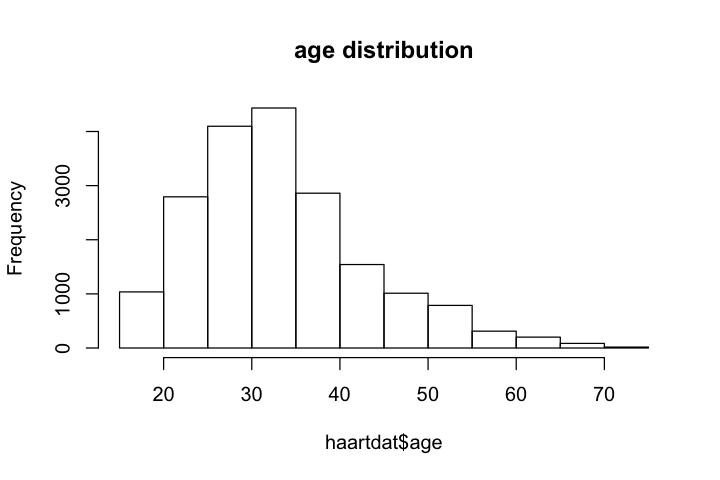

In [9]:
hist(haartdat$age, main='age distribution')

- event is an indicator for death at the end of the interval (0 = alive/1 = died),  sex is sex (0 = male/1 = female),

- age is age at the start of follow-up (years),

- cd4.sqrt is the square root of CD4 count, measured at the end of each interval, but before haartind. Note that in each row, corresponding to time point j in individual i, cd4.sqrt has an effect on haartind in the same row, including at time 0.

# Naive model

In [12]:
m0 = coxph(Surv(tstart, fuptime, event) ~ haartind +  cluster(patient), 
              data = haartdat)

print(screenreg(m0,include.zph = FALSE))


             Model 1  
----------------------
haartind        -0.59 
                (0.43)
----------------------
AIC            390.28 
R^2              0.00 
Max. R^2         0.02 
Num. events     31    
Num. obs.    19175    
Missings         0    
*** p < 0.001, ** p < 0.01, * p < 0.05


# Incorrect model with time-varying controls

In [15]:
m1 = coxph(Surv(tstart, fuptime, event) ~ haartind +  cd4.sqrt + age + sex +  cluster(patient), 
              data = haartdat)

print(screenreg(m1,include.zph = FALSE))


             Model 1     
-------------------------
haartind        -0.62    
                (0.42)   
cd4.sqrt        -0.13 ** 
                (0.05)   
age              0.06 ***
                (0.02)   
sex              0.04    
                (0.45)   
-------------------------
AIC            366.73    
R^2              0.00    
Max. R^2         0.02    
Num. events     31       
Num. obs.    19175       
Missings         0       
*** p < 0.001, ** p < 0.01, * p < 0.05


# MSM

- In general, people don't control again for time-invariant covariates

In [18]:
temp <- ipwtm(exposure = haartind, family = "survival", 
              numerator = ~ sex + age, 
              denominator = ~ cd4.sqrt + sex + age, id = patient, 
              tstart = tstart, timevar = fuptime, type = "first", data = haartdat)

temp2 <- ipwtm(exposure = dropout, family = "survival",
               numerator = ~ sex + age, denominator = ~ cd4.sqrt + sex + age, 
               id = patient, tstart = tstart, timevar = fuptime, 
               type = "first",
              data = haartdat)

m2 = coxph(Surv(tstart, fuptime, event) ~ haartind +  cluster(patient), 
              data = haartdat, weights = temp$ipw.weights*temp2$ipw.weights)

print(screenreg(m2, include.zph = FALSE))


             Model 1   
-----------------------
haartind        -0.94 *
                (0.45) 
-----------------------
AIC            447.93  
R^2              0.00  
Max. R^2         0.02  
Num. events     31     
Num. obs.    19175     
Missings         0     
*** p < 0.001, ** p < 0.01, * p < 0.05


If I control for time-invariant variables, coefficient only changes slightly. 

In [20]:
m3 = coxph(Surv(tstart, fuptime, event) ~ haartind + sex + age + cluster(patient), 
              data = haartdat, weights = temp$ipw.weights*temp2$ipw.weights)

print(screenreg(m3, include.zph = FALSE))


             Model 1     
-------------------------
haartind        -0.96 *  
                (0.45)   
sex              0.10    
                (0.45)   
age              0.06 ***
                (0.02)   
-------------------------
AIC            433.23    
R^2              0.00    
Max. R^2         0.02    
Num. events     31       
Num. obs.    19175       
Missings         0       
*** p < 0.001, ** p < 0.01, * p < 0.05


# My mistake

Controlling for everything again.

In [21]:
m4 = coxph(Surv(tstart, fuptime, event) ~ haartind + cd4.sqrt + sex + age +   cluster(patient), 
              data = haartdat, weights = temp$ipw.weights*temp2$ipw.weights)

print(screenreg(m4, include.zph = FALSE))


             Model 1     
-------------------------
haartind        -0.55    
                (0.44)   
cd4.sqrt        -0.18 ***
                (0.05)   
sex              0.04    
                (0.46)   
age              0.06 ***
                (0.02)   
-------------------------
AIC            402.06    
R^2              0.00    
Max. R^2         0.02    
Num. events     31       
Num. obs.    19175       
Missings         0       
*** p < 0.001, ** p < 0.01, * p < 0.05


# Do you see the problem?

- I should be using model 3 (doesn't work for PSID) or model 4. 

In [23]:
print(screenreg(list(m0, m1, m2, m3, m4)), include.zph = FALSE)


             Model 1    Model 2       Model 3     Model 4       Model 5     
----------------------------------------------------------------------------
haartind        -0.59      -0.62         -0.94 *     -0.96 *       -0.55    
                (0.43)     (0.42)        (0.45)      (0.45)        (0.44)   
cd4.sqrt                   -0.13 **                                -0.18 ***
                           (0.05)                                  (0.05)   
age                         0.06 ***                  0.06 ***      0.06 ***
                           (0.02)                    (0.02)        (0.02)   
sex                         0.04                      0.10          0.04    
                           (0.45)                    (0.45)        (0.46)   
----------------------------------------------------------------------------
AIC            390.28     366.73        447.93      433.23        402.06    
R^2              0.00       0.00          0.00        0.00          0.00   